In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directories
train_dir = 'archive/chest_xray/train'
test_dir = 'archive/chest_xray/test'

# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
test_datagen = ImageDataGenerator(rescale=1./255)



In [10]:
# Images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'  # binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for matching labels when evaluating
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Custom 15 layer CNN Model + adding weights to dataset 

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import numpy as np

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # New layers
    Conv2D(256, (3,3), activation='relu'), 
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

C:\Users\ameen\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [15]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    class_weight=class_weights
)


C:\Users\ameen\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.4087 - loss: 0.6581 - val_accuracy: 0.7917 - val_loss: 0.4533
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.8483 - loss: 0.3274 - val_accuracy: 0.8077 - val_loss: 0.4095
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8726 - loss: 0.2708 - val_accuracy: 0.7292 - val_loss: 0.6025
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8863 - loss: 0.2639 - val_accuracy: 0.8333 - val_loss: 0.4034
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9118 - loss: 0.2071 - val_accuracy: 0.8558 - val_loss: 0.3575
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.9272 - loss: 0.1793 - val_accuracy: 0.8750 - val_loss: 0.3045
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9334 - loss: 0.1595 - val_accuracy: 0.8878 - val_loss: 0.2852
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.9443 - loss: 0.1470 - val_accu

In [16]:
# Evaluate on validation set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 515ms/step - accuracy: 0.6090 - loss: 1.0777
Test Accuracy: 0.77


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
test_generator.reset()
pred_probs = model.predict(test_generator)
pred_classes = (pred_probs > 0.5).astype(int).flatten()

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 515ms/step
              precision    recall  f1-score   support

      NORMAL       0.98      0.40      0.57       234
   PNEUMONIA       0.73      0.99      0.85       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.71       624
weighted avg       0.83      0.77      0.74       624



In [ ]:
import numpy as np

# Get predicted probabilities (sigmoid outputs)
test_generator.reset()
y_pred_probs = model.predict(test_generator)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step


<Figure size 600x600 with 0 Axes>

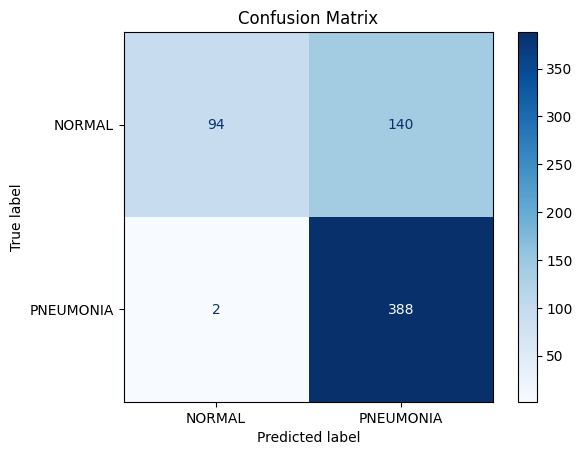

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

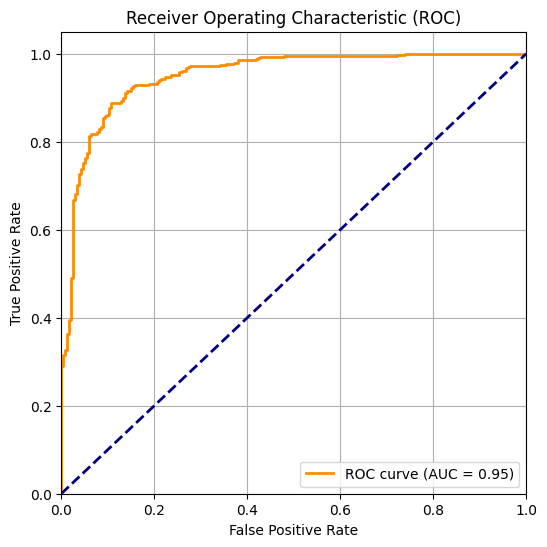

In [20]:
from sklearn.metrics import roc_curve, auc

# Get the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


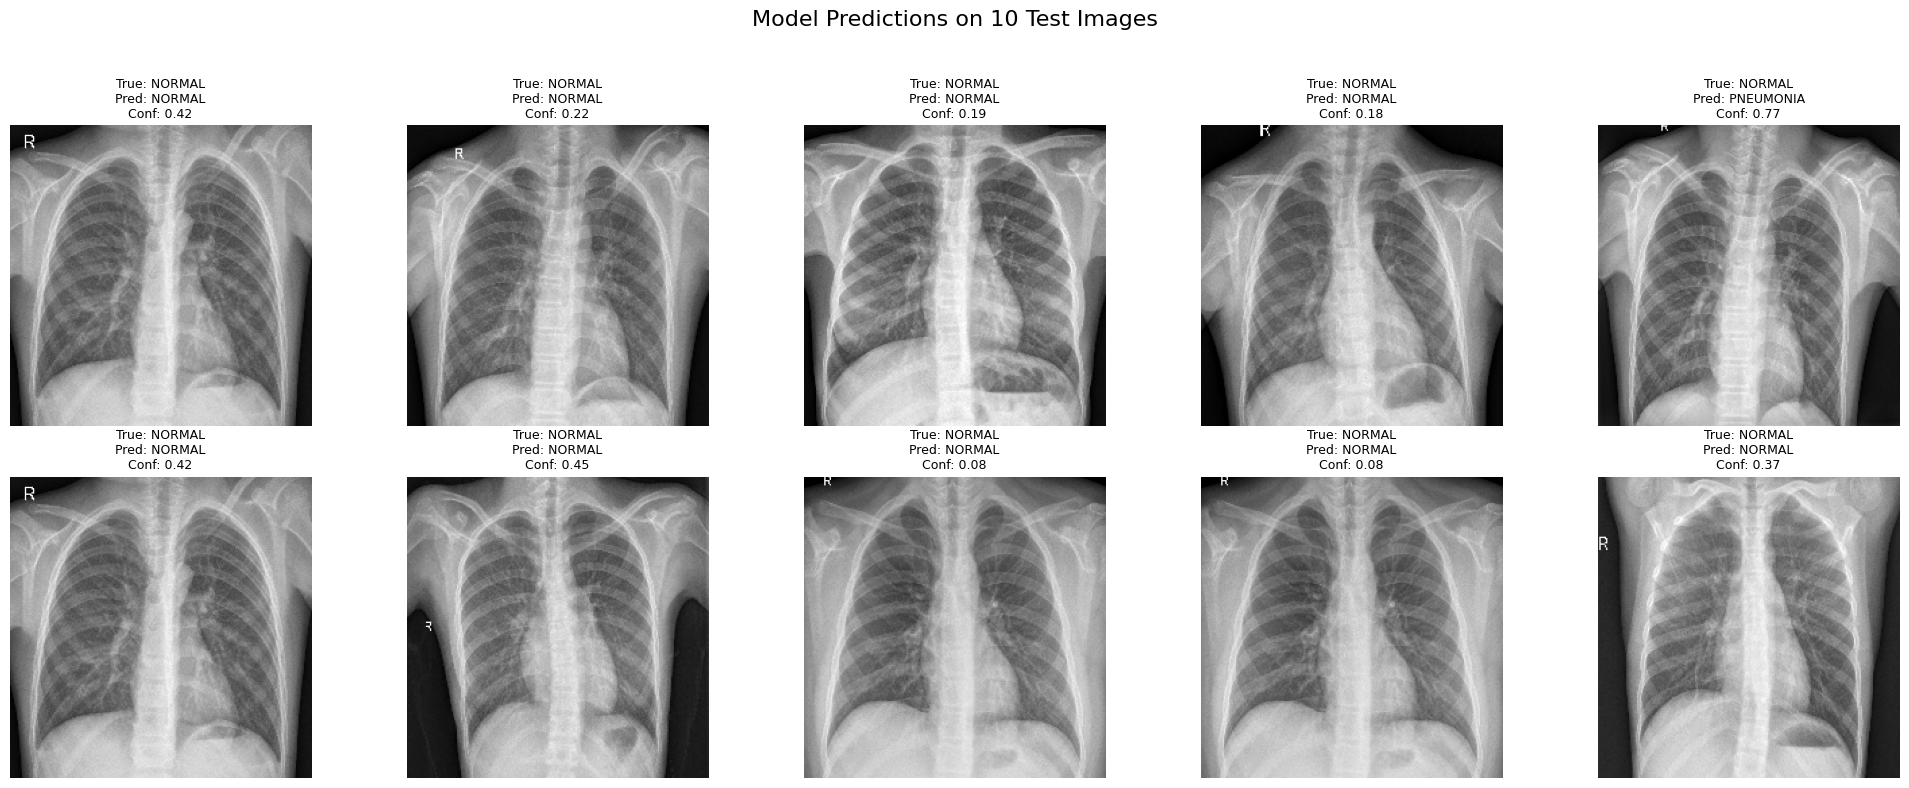

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing import image

class_names = list(test_generator.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

test_images, test_labels = next(test_generator) 
pred_probs = model.predict(test_images)
pred_classes = (pred_probs > 0.5).astype(int).flatten()

num_images = 10
plt.figure(figsize=(20, 8))

for i in range(num_images):
    idx = random.randint(0, len(test_images) - 1)
    plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[idx])
    plt.axis('off')
    
    true_label = class_names[int(test_labels[idx])]
    predicted_label = class_names[pred_classes[idx]]
    confidence = pred_probs[idx][0]

    plt.title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}", fontsize=9)

plt.suptitle("Model Predictions on 10 Test Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

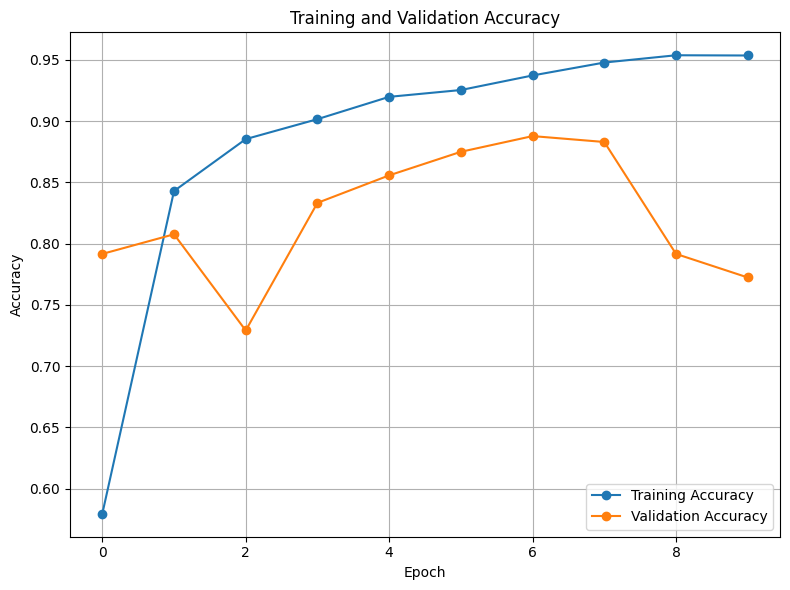

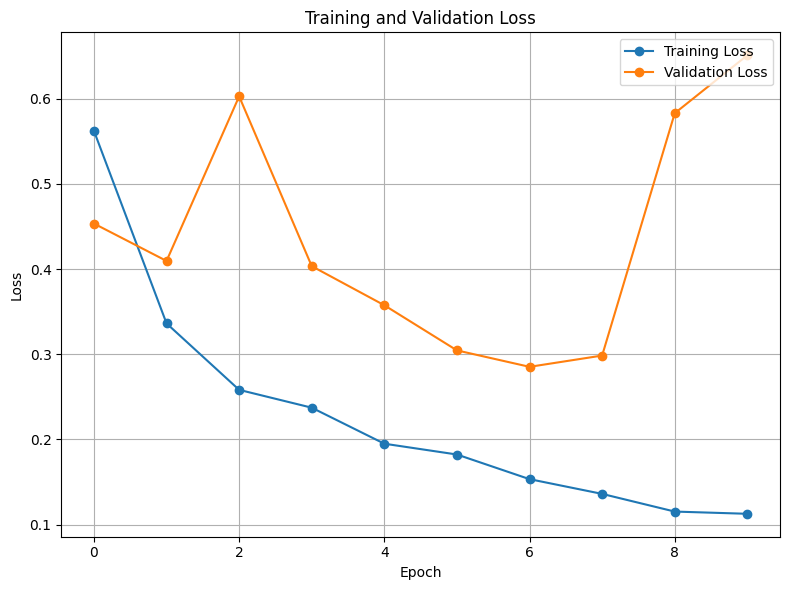

In [22]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
